# Comparing Speeds of the Paths and Hybrid Methods

We have two potential methods for building the variance-covariance matrix between nodes in the ARG. Here, you will find an explanation of each method followed by a benchmark that compares the methods' speeds on various ARGs.

## Paths Method

A 'path' is a route from a node back to the GMRCA of the ARG. First, calculate all of the paths from the sample nodes (tips) and store these paths in a list. Calculate a single path from each of the internal nodes, excluding the root and append this to the list of paths. We only need a single path from each internal node, even if there are multiple possible paths. Loop over every pair of paths and calculate the amount of intersection between the two paths; this is equal to the covariance between the paths. We can loop efficiently by avoiding redundant pairs. Build a matrix of these covariances.

In [202]:
import msprime
import tskit
import numpy as np
import math
import random
from collections import defaultdict
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt    
import time


def ts_to_nx(ts, connect_recombination_nodes=False, recomb_nodes=[]):
    """
    Converts tskit tree sequence to networkx graph.
    """
    topology = defaultdict(list)
    for tree in ts.trees():
        for k, v in chain(tree.parent_dict.items()):
            if connect_recombination_nodes:
                if recomb_nodes == []:
                    recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
                if v in recomb_nodes and recomb_nodes.index(v)%2 == 1:
                    v -= 1
                if k in recomb_nodes and recomb_nodes.index(k)%2 == 1:
                    k -= 1
                if v not in topology[k]:
                    topology[k].append(v)
            else:
                if v not in topology[k]:
                    topology[k].append(v)
    nx_graph = nx.MultiDiGraph(topology)
    return nx_graph

def identify_unique_paths(ts):
    """
    Finds all of the paths within the incomplete ARG, stored as a tskit tree sequence
    
    Input:
    - ts: tskit tree sequence
    
    Output:
    - all_paths: list, unique paths within the ARG
    """
    G = ts_to_nx(ts=ts)
    
    #unique paths up the ARG
    gmrca = ts.node(ts.num_nodes-1).id
    all_paths = []
    for sample in ts.samples():
        paths = nx.all_simple_paths(G, source=sample, target=gmrca)
        all_paths.extend(paths)
    return all_paths

def create_sample_locations_array(paths, sample_locs):
    """
    Expands sample locations to pair with the unique paths. Accounts for samples having multiple
    paths.
    
    Inputs:
    - paths: list, unique paths within the ARG. Output of identify_unique_paths(). If not
        provided, this will be calculated
    - sample_locs: numpy array, sample locations
    
    Output:
    - path_locs: numpy array, sample locations expanded to match number of paths
    """
    sample_locs_array = []
    for path in paths:
        sample_locs_array.append([sample_locs[path[0]]])
    path_locs = np.array(sample_locs_array)
    return path_locs

def link_node_with_path(ts, paths):
    """
    Adds paths from internal nodes to the root to the paths list used for calculating the
    covariance matrix. Could potentially only do one of the two recombination nodes, but keeping
    it simple for now

    Inputs:
    - ts: tskit tree sequence
    - paths: list, unique paths within the ARG. Output of identify_unique_paths().

    Output:
    - path_list: list, updated paths list
    """
    path_list = []
    for node in ts.nodes():
        if node.flags == tskit.NODE_IS_SAMPLE or node.time == ts.max_root_time:
            continue
        for i in range(len(paths)):
            if node.id in paths[i]:
                path_list.append(paths[i][paths[i].index(node.id):])
                break
    return path_list

def calc_covariance_matrix(paths, ts):
    """
    Calculates the covariance matrix between paths in a full ARG, stored as a tskit tree sequence.
    
    Inputs:
    - paths: list, unique paths within the ARG. Output of identify_unique_paths()
    - ts: tskit tree sequence. Needed for node times
    
    Output:
    - times: numpy array, shared times between the paths within the ARG
    """
    edges = ts.tables.edges
    parent_list = list(edges.parent)
    child_list = list(edges.child)
    gmrca = ts.node(ts.num_nodes-1).id
    tgmrca = ts.node(gmrca).time
    times = np.empty((len(paths),len(paths)))
    tree = ts.first()
    for i, p in enumerate(paths):
        for j in range(i+1):
            intersect = list(set(p).intersection(paths[j]))
            if i == j:
                times[i,j] = tgmrca
            elif intersect == [gmrca]:
                times[i,j] = 0
            else:
                edges = []
                for child in intersect:
                    if child != gmrca:
                        edges.append(ts.node(parent_list[child_list.index(child)]).time - ts.node(child).time)
                times[i,j] = np.sum(edges) # Do I need np.unique()? Ask Matt, because it was previously in his
            times[j,i] = times[i,j]
    return times
    
def locate_mle_gmrca(inv_sigma_22, sample_locs):
    """
    Locates the maximum likelihood estimate of the grand most recent common ancestor based on the covariance
    matrix between paths and sample locations (Equation 5.6 from 
    https://lukejharmon.github.io/pcm/pdf/phylogeneticComparativeMethods.pdf). Currently, requires simga_22
    to be pre-inverted (may be worth adding both options in future).
    
    Inputs:
    - inv_sigma_22: numpy array, inverted covariance matrix between paths at sample time
    - sample_locs: numpy array, sample locations expanded to match number of paths. Output of
        create_sample_locations_array().
    
    Output:
    - u1: float, maximum likelihood estimate of the grand most recent common ancestor (GMRCA). Output of 
        locate_mle_gmrca().
    """
    k = len(inv_sigma_22)
    a1 = np.matmul(np.matmul(np.ones(k), inv_sigma_22), np.ones(k).reshape(-1,1))
    a2 = np.matmul(np.matmul(np.ones(k), inv_sigma_22), sample_locs)
    u1 = a2/a1
    return u1

def estimate_mle_dispersal(Tinv, locs):
    '''
    MLE dispersal estimate
    
    parameters
    ----------
    Tinv: inverse covariance matrix among sample locations
    locs: sample locations
    '''
    
    k = len(locs) #number of paths
    # find MLE MRCA location (eqn 5.6 Harmon book)
    a1 = np.matmul(np.matmul(np.ones(k), Tinv), np.ones(k).reshape(-1,1))
    a2 = np.matmul(np.matmul(np.ones(k), Tinv), locs)
    ahat = a2/a1
    # find MLE dispersal rate (eqn 5.7 Harmon book)
    x = locs.reshape(-1,1) #make locations a column vector
    R1 = x - ahat * np.ones(k).reshape(-1,1)
    Rhat = np.matmul(np.matmul(np.transpose(R1), Tinv), R1) / (k-1)
    return Rhat[0]

def reconstruct_node_locations(ts, paths, sample_locs):
    """
    Calculates the location of ancestral nodes using conditional multivariate normal distribution.

    Inputs:
    - ts: tskit tree sequence. Needed for node times
    - paths: list, unique paths within the ARG. Output of identify_unique_paths()
    - sample_locs: list of sample locations, one location per sample

    Outputs:
    - node_times: list, time of nodes from present
    - node_locs: list, location of nodes
    """
    sample_locs_array = create_sample_locations_array(paths=paths, sample_locs=sample_locs) # expands locs
    node_paths = link_node_with_path(ts=ts, paths=paths)
    all_paths = node_paths + paths
    sigma = calc_covariance_matrix(paths=all_paths, ts=ts)
    np.savetxt("path_CM.csv", sigma, delimiter=",")
    sigma_11 = sigma[0:sigma.shape[0]-len(paths),0:sigma.shape[1]-len(paths)]
    sigma_12 = sigma[0:sigma.shape[0]-len(paths),sigma.shape[1]-len(paths):sigma.shape[1]]
    sigma_21 = sigma[sigma.shape[0]-len(paths):sigma.shape[0],0:sigma.shape[1]-len(paths)]
    sigma_22 = sigma[sigma.shape[0]-len(paths):sigma.shape[0],sigma.shape[1]-len(paths):sigma.shape[1]]
    inv_sigma_22 = np.linalg.pinv(sigma_22)
    dispersal_rate = estimate_mle_dispersal(inv_sigma_22, sample_locs_array)
    u1 = locate_mle_gmrca(inv_sigma_22=inv_sigma_22, sample_locs=sample_locs_array)
    cmvn_u = u1 + np.dot(np.dot(sigma_12, inv_sigma_22),sample_locs_array - u1)
    cmvn_sigma = sigma_11 - np.dot(np.dot(sigma_12, inv_sigma_22), sigma_21)
    node_times = ts.tables.nodes.time
    node_locs = np.concatenate((sample_locs, np.transpose(cmvn_u)[0], u1))
    return node_times, node_locs, dispersal_rate

In [205]:
ts = msprime.sim_ancestry(
    samples=2,
    recombination_rate=1e-8,
    sequence_length=2000,
    population_size=10_000,
    record_full_arg=True
)

print(ts.draw_text())

print(ts.tables)

29202.66┊  15     ┊  15     ┊          ┊         ┊  
        ┊ ┏━┻━┓   ┊ ┏━┻━┓   ┊          ┊         ┊  
23090.26┊ ┃  14   ┊ ┃  14   ┊          ┊         ┊  
        ┊ ┃   ┃   ┊ ┃   ┃   ┊          ┊         ┊  
19352.01┊ ┃  12   ┊ ┃  13   ┊          ┊         ┊  
        ┊ ┃   ┃   ┊ ┃   ┃   ┊          ┊         ┊  
16573.60┊ ┃  11   ┊ ┃  11   ┊   11     ┊         ┊  
        ┊ ┃   ┃   ┊ ┃   ┃   ┊ ┏━━┻━━┓  ┊         ┊  
14628.56┊ ┃   ┃   ┊ ┃   ┃   ┊ 10    ┃  ┊  10     ┊  
        ┊ ┃   ┃   ┊ ┃   ┃   ┊ ┃     ┃  ┊ ┏━┻━┓   ┊  
12614.13┊ 8   ┃   ┊ 8   ┃   ┊ 9     ┃  ┊ 9   ┃   ┊  
        ┊ ┃   ┃   ┊ ┃   ┃   ┊ ┃     ┃  ┊ ┃   ┃   ┊  
7706.77 ┊ ┃   6   ┊ ┃   6   ┊ ┃     6  ┊ ┃   7   ┊  
        ┊ ┃   ┃   ┊ ┃   ┃   ┊ ┃     ┃  ┊ ┃   ┃   ┊  
7246.17 ┊ ┃   5   ┊ ┃   5   ┊ ┃     5  ┊ ┃   5   ┊  
        ┊ ┃  ┏┻━┓ ┊ ┃  ┏┻━┓ ┊ ┃   ┏━┻┓ ┊ ┃  ┏┻━┓ ┊  
1091.57 ┊ ┃  4  ┃ ┊ ┃  4  ┃ ┊ ┃   4  ┃ ┊ ┃  4  ┃ ┊  
        ┊ ┃ ┏┻┓ ┃ ┊ ┃ ┏┻┓ ┃ ┊ ┃  ┏┻┓ ┃ ┊ ┃ ┏┻┓ ┃ ┊  
0.00    ┊ 0 1 2 3 ┊ 0 1 2 3 ┊ 0  1 2 3 ┊ 0 1 2

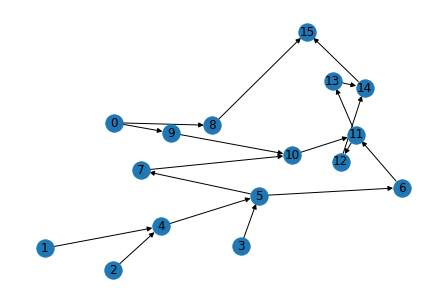

In [206]:
paths = identify_unique_paths(ts=ts)

sample_locs = np.linspace(0, 1, ts.num_samples) # evenly space the samples, ignore ordering of tree samples

times, locations, dispersal_rate = reconstruct_node_locations(
    ts=ts,
    paths=paths,
    sample_locs=sample_locs
)

## Hybrid Method

43583.12┊                                                   ┊                              47                   ┊                              47                   ┊                           47                      ┊  
        ┊                                                   ┊               ┏━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━┓   ┊               ┏━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━┓   ┊             ┏━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┓       ┊  
28055.87┊                                                   ┊               ┃                              46   ┊               ┃                              46   ┊             ┃                            46       ┊  
        ┊                                                   ┊               ┃                               ┃   ┊               ┃                               ┃   ┊             ┃                         ┏━━━┻━━━┓   ┊  
18337.09┊                              45                   ┊               ┃                              45   ┊       

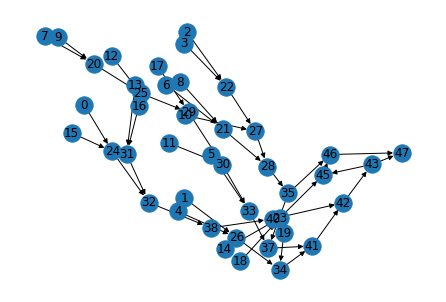

In [188]:
import numpy as np
import math
import random
from collections import defaultdict
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt
import graphviz

       

def locate_loops(g, cycle_root=-1):
    """
    Finds loops within the ARG. I thought that it would be easiest to utilize functions from
    networkx package. Identifies recombination events, converts the tree sequence into a networkx
    graph. The paired recombination nodes are merged together in this graph. Converts graph to 
    undirected, then calculates cycle basis. This does not identify 'bubbles', so we need to add
    an extra step to this.
    """
    
    if cycle_root < 0:
        cycle_root = list(g.nodes())[0]
    recomb_nodes = [ x for x in g.nodes() if len(list(g.successors(x))) == 2 ]
    # print(recomb_nodes)
    g_un = g.to_undirected()
    loop_list = nx.cycle_basis(g_un, root=cycle_root)
    if len(loop_list) != len(recomb_nodes):
        for node in recomb_nodes:
            parent = list(g.successors(node))[0]
            loop_list.append([node, parent])  
    return loop_list

def group_loops(loops, plot=False):
    """
    Groups intersecting loops in list. Builds networkx graph based on the loop list. Determines
    if the nodes are connected through the graph. Returns a list of lists of loops.
    """
    
    num_loops = len(loops)
    if num_loops == 0:
        return []
    else:
        if num_loops > 1:
            build_instructions = []
            for loop in loops:
                for n in range(len(loop)):
                    if n == len(loop)-1:
                        a, b = loop[n], loop[0]
                    else:
                        a, b = loop[n], loop[n+1]
                    build_instructions.append([a, b])
            g = nx.Graph(build_instructions)
            grouped_nodes = list(nx.connected_components(g))
            if plot:
                nx.draw(g, with_labels=True)
            grouped_loops = [[] for i in range(len(grouped_nodes))]
            for loop in loops:
                for i in range(len(grouped_loops)):
                    if loop[0] in grouped_nodes[i]:
                        grouped_loops[i].append(loop)
            return grouped_loops
        else:
            return [loops]

    
def Cov(edge_path1,edge_path2,G):
    """ 
    edge_path1 : A path in the graph G as a list of edges 
    edge_path2 : A path in the graph G as a list of edges 
    G : A graph G in which the paths exist and the nodes have an attribute time
    returns the Covariance between the two paths = the shared time between the two paths in G.
    """
    # edges_path1 = set(path_to_edges(path1))
    # edges_path2 = set(path_to_edges(path2))
    # print('check',edge_path2)
    common_edges = set(edge_path1).intersection(set(edge_path2))
    cov = 0 
    for edge in common_edges:
        t_edge = G.nodes()[edge[1]]['time'] - G.nodes()[edge[0]]['time']
        cov += t_edge 
    return cov 

def ts_to_nx(ts, connect_recombination_nodes=False, recomb_nodes=[]):
    """
    Converts tskit tree sequence to networkx graph.
    """
    if recomb_nodes == []:
        recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
    recomb_nodes_to_remove = recomb_nodes[1::2]
    topology = defaultdict(list)
    for tree in ts.trees():
        for k, v in chain(tree.parent_dict.items()):
            if connect_recombination_nodes:
                if v in recomb_nodes_to_remove:
                    v -= 1
                if k in recomb_nodes_to_remove:
                    k -= 1
                if v not in topology[k]:
                    topology[k].append(v)
            else:
                if v not in topology[k]:
                    topology[k].append(v)
    nx_graph = nx.DiGraph(topology)
    node_times = {v: k for v, k in enumerate(ts.tables.nodes.time)}
    nx.set_node_attributes(nx_graph, node_times, "time")
    return nx_graph

print(ts.draw_text())

Sample_Nodes = list(ts.samples())
G = ts_to_nx(ts=ts, connect_recombination_nodes=True)

nx.draw(G, with_labels=True)

"""Locating the loops using James' Method""" 
loops = locate_loops(g=G) #Identify each loop as a list of nodes 
grouped_loops = group_loops(loops=loops) #Group the loops if they shared edges

In [168]:
""" Finding the GMRCA """
vGMRCA = max(list(G.nodes()), key = lambda nd:G.nodes()[nd]['time'] ) #This is the GMRCA of the entire ARG identified as the oldest node in the ARG 

""" Storing some information about the loops we will repeatedly use """
nodes_in_all_groups = [] #This will store all the nodes present in any loop in the Graph 
Grp_details = {} #This will store information about each group of nodes including the index of the group, the nodes in the group and the oldest node in the group
ind = 0 #This will keep track of the number of groups of loops present 
for Lp_grp in grouped_loops: 
    nodes_in_group = [] #To keep track of nodes in a given group of loops 
    for lp in Lp_grp: 
        nodes_in_group += lp
        nodes_in_all_groups += lp
    Grp_details[ind] = {'ind':ind, 'nodes': nodes_in_group, 'maximum': max(nodes_in_group, key = lambda nd: G.nodes()[nd]['time']) }
    ind += 1 
nodes_in_all_groups = set(nodes_in_all_groups)

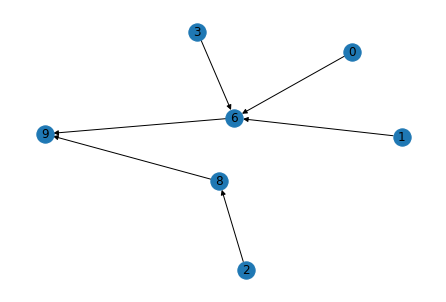

In [169]:
""" Break the graph in "irreducible" components of trees and loops """
G_skeleton = nx.DiGraph() #This will record connection nodes after we break down the ARG into simple components (trees and loops)
S = Sample_Nodes
while len(S) > 0 :
    sample_connects = {} #For each s in S, this will record the earliest ancestor of s that is part of any loop
    for s in S: 
        if s == vGMRCA : 
            continue 
        
        group_connections = [vGMRCA] #This list will containt all the nodes in any loop that s is connected to. vGMRCA is included here for algorithmic purposes. 
        for g in nodes_in_all_groups : 
            if nx.has_path(G,s,g) and s != g:  
                group_connections += [g]
        
        earliest_connection = min(group_connections, key = lambda nd: G.nodes()[nd]['time']  )#Choose the earliest in group_connection
        sample_connects[s] = earliest_connection
        G_skeleton.add_node(earliest_connection, time= G.nodes()[earliest_connection]['time'] )
        G_skeleton.add_edge(s,earliest_connection, typ ='tree', paths = list(nx.all_simple_edge_paths(G,s,earliest_connection)) ) #To each edge in the skeleton, we all attribute all the paths between the two nodes in the real Graph. The attribute typ keeps track of whether this edge is part of a loop or a tree. typ attribute was mainly included for verification purposes and can eventually be removed. 
    
    loop_st_nds = list(sample_connects.values()) #This is the list of nodes in the loops which are connected to S 
    loop_st_nds_grpwise = { ind: list( set(Grp_details[ind]['nodes']).intersection(set(loop_st_nds))) for ind in Grp_details if len(list( set(Grp_details[ind]['nodes']).intersection(set(loop_st_nds)))) != 0 } #We divide and label these nodes according the group of loops they belong to.
    
    S_new = [] #The next set of S will be the the MRCA of each loop involved in this step
    for ind in loop_st_nds_grpwise : 
        loop_MRCA = Grp_details[ind]['maximum']
        S_new += [loop_MRCA]
        G_skeleton.add_node( loop_MRCA )
        for v in loop_st_nds_grpwise[ind]: 
            G_skeleton.add_edge(v,loop_MRCA, typ='loop', paths = list(nx.all_simple_edge_paths(G,v,loop_MRCA)))
    S = S_new
    # print('S',S)

nx.draw(G_skeleton, with_labels=True)

In [170]:
""" Compute the Matrix """
Gske_nodes = sorted(G_skeleton.nodes, key = lambda nd:G.nodes()[nd]['time']) #Ordering the nodes in the skeleton according to their times

#To each node in G_skeleton we will associcate two matrices. CovMatrix of a nodes will be the covariance matrix of all the paths from its immediate predecessor to itself where the CovFullMatrix will be the covariance matrix from the samples to itself. 

for v in Gske_nodes: 
    if v in Sample_Nodes:
        G_skeleton.add_node(v, CovMatrix = np.matrix([0]), CovMatrixFull = np.matrix([0]))
    else:    
        v_pred  = list(sorted(G_skeleton.predecessors(v), key = lambda nd:G.nodes()[nd]['time'])) #The predecessors nodes of v
        n_pred = len(v_pred)
        CovMat = {} #This will record the CovMatrix between all the paths from the predecessors to v. This is stored as a dictionary of dictonary. The [v1][v2] entry is the covariance between paths from v1 to v and v2 to v. 
        CovMatFull = [] #This will record the CovMatrixFull which the covariance matrix from all paths from the samples to v
        for v1 in v_pred:
            Covrow = {}
            CovFullrow = []
            
            v1_paths = G_skeleton.edges()[(v1,v)]['paths']
            n1 = len(v1_paths)
            v1FullMat = G_skeleton.nodes()[v1]['CovMatrixFull'] #The covariance matrix between all paths from the samples to v1
            m1 = len(v1FullMat)
            
            for v2 in v_pred : 
                #print('v2',v2)
                v2_paths = G_skeleton.edges()[(v2,v)]['paths']
                n2 = len(v2_paths)
                v2FullMat = G_skeleton.nodes()[v2]['CovMatrixFull'] #The covariance matrix between all paths from the samples to v2
                m2 = len(v2FullMat)
                
                Matv1v2 = np.matrix( [ [ Cov(path1,path2,G) for path2 in v2_paths] for path1 in v1_paths ] )
                MatFullv1v2 = np.kron(np.matrix(np.ones( (m1,m2) )), Matv1v2 )
                #print('Matv1v2',Matv1v2)
                #print('MatFullv1v2',MatFullv1v2)
                if v1 == v2 :
                    MatFullv1v2 = MatFullv1v2 + np.kron( v1FullMat, np.matrix(np.ones( (n1,n1) )) ) 
                Covrow[v2] = Matv1v2
                CovFullrow += [ MatFullv1v2 ]
            CovMat[v1] = Covrow
            CovMatFull += [CovFullrow ]
        
        G_skeleton.add_node(v, CovMatrix = CovMat, CovMatrixFull = np.bmat(CovMatFull))
CMFull = G_skeleton.nodes()[vGMRCA]['CovMatrixFull'] 

np.savetxt("CMFull.csv", CMFull, delimiter=",")

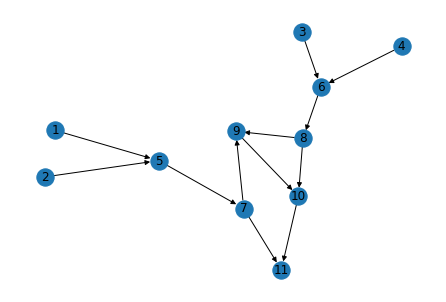

In [150]:
import numpy as np
import math
import random
from collections import defaultdict
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt
import graphviz

       

def locate_loops(g, cycle_root=-1):
    """
    Finds loops within the ARG. I thought that it would be easiest to utilize functions from
    networkx package. Identifies recombination events, converts the tree sequence into a networkx
    graph. The paired recombination nodes are merged together in this graph. Converts graph to 
    undirected, then calculates cycle basis. This does not identify 'bubbles', so we need to add
    an extra step to this.
    """
    
    if cycle_root < 0:
        cycle_root = list(g.nodes())[0]
    recomb_nodes = [ x for x in g.nodes() if len(list(g.successors(x))) == 2 ]
    # print(recomb_nodes)
    g_un = g.to_undirected()
    loop_list = nx.cycle_basis(g_un, root=cycle_root)
    if len(loop_list) != len(recomb_nodes):
        for node in recomb_nodes:
            parent = list(g.successors(node))[0]
            loop_list.append([node, parent])  
    return loop_list

def group_loops(loops, plot=False):
    """
    Groups intersecting loops in list. Builds networkx graph based on the loop list. Determines
    if the nodes are connected through the graph. Returns a list of lists of loops.
    """
    
    num_loops = len(loops)
    if num_loops == 0:
        return []
    else:
        if num_loops > 1:
            build_instructions = []
            for loop in loops:
                for n in range(len(loop)):
                    if n == len(loop)-1:
                        a, b = loop[n], loop[0]
                    else:
                        a, b = loop[n], loop[n+1]
                    build_instructions.append([a, b])
            g = nx.Graph(build_instructions)
            grouped_nodes = list(nx.connected_components(g))
            if plot:
                nx.draw(g, with_labels=True)
            grouped_loops = [[] for i in range(len(grouped_nodes))]
            for loop in loops:
                for i in range(len(grouped_loops)):
                    if loop[0] in grouped_nodes[i]:
                        grouped_loops[i].append(loop)
            return grouped_loops
        else:
            return [loops]

    
def Cov(edge_path1,edge_path2,G):
    """ 
    edge_path1 : A path in the graph G as a list of edges 
    edge_path2 : A path in the graph G as a list of edges 
    G : A graph G in which the paths exist and the nodes have an attribute time
    returns the Covariance between the two paths = the shared time between the two paths in G.
    """
    # edges_path1 = set(path_to_edges(path1))
    # edges_path2 = set(path_to_edges(path2))
    # print('check',edge_path2)
    common_edges = set(edge_path1).intersection(set(edge_path2))
    cov = 0 
    for edge in common_edges:
        t_edge = G.nodes()[edge[1]]['time'] - G.nodes()[edge[0]]['time']
        cov += t_edge 
    return cov 


G = nx.DiGraph() #This will record the real ARG

#Example 1
#Sample_Nodes = [1,2,3,4,5,6,7,8] 
#n_nodes = 23 # The number of nodes
#edgelist = [(1,9),(2,9),(3,11),(4,12),(5,10),(6,10),(7,13),(8,20),(9,11),(10,12),(11,14),(12,13),(13,15),(14,16),(14,18),(15,16),(15,17),(16,17),(17,18),(18,19),(19,21),(19,23),(20,21),(20,22),(21,22),(22,23)]

#Example 2
Sample_Nodes = [1,2,3,4]
n_nodes = 11
edgelist = [(1,5),(2,5),(3,6),(4,6),(5,7),(6,8),(7,9),(7,11),(8,9),(8,10),(9,10),(10,11)]

"""Building the ARG as a Directed Graph"""
for nd in range(1,n_nodes+1) :
    if nd in Sample_Nodes : 
        G.add_node(nd, time = 0)
        G_skeleton.add_node(nd)
    else : 
        G.add_node(nd, time = nd)
G.add_edges_from(edgelist)

"""Locating the loops using James' Method""" 
loops = locate_loops(g=G) #Identify each loop as a list of nodes 
grouped_loops = group_loops(loops=loops) #Group the loops if they shared edges

""" Finding the GMRCA """
vGMRCA = max(list(G.nodes()), key = lambda nd:G.nodes()[nd]['time'] ) #This is the GMRCA of the entire ARG identified as the oldest node in the ARG 

""" Storing some information about the loops we will repeatedly use """
nodes_in_all_groups = [] #This will store all the nodes present in any loop in the Graph 
Grp_details = {} #This will store information about each group of nodes including the index of the group, the nodes in the group and the oldest node in the group
ind = 0 #This will keep track of the number of groups of loops present 
for Lp_grp in grouped_loops: 
    nodes_in_group = [] #To keep track of nodes in a given group of loops 
    for lp in Lp_grp: 
        nodes_in_group += lp
        nodes_in_all_groups += lp
    Grp_details[ind] = {'ind':ind, 'nodes': nodes_in_group, 'maximum': max(nodes_in_group, key = lambda nd: G.nodes()[nd]['time']) }
    ind += 1 
nodes_in_all_groups = set(nodes_in_all_groups)

nx.draw(G, with_labels=True)

7 [1, 2]
v2 1
n2 1
Matv1v2 [[7]]
MatFullv1v2 [[7.]]
v2 2
n2 1
Matv1v2 [[2]]
MatFullv1v2 [[2.]]
v2 1
n2 1
Matv1v2 [[2]]
MatFullv1v2 [[2.]]
v2 2
n2 1
Matv1v2 [[7]]
MatFullv1v2 [[7.]]
8 [3, 4]
v2 3
n2 1
Matv1v2 [[8]]
MatFullv1v2 [[8.]]
v2 4
n2 1
Matv1v2 [[2]]
MatFullv1v2 [[2.]]
v2 3
n2 1
Matv1v2 [[2]]
MatFullv1v2 [[2.]]
v2 4
n2 1
Matv1v2 [[8]]
MatFullv1v2 [[8.]]
11 [7, 8]
v2 7
n2 2
Matv1v2 [[4 0]
 [0 4]]
MatFullv1v2 [[4. 0. 4. 0.]
 [0. 4. 0. 4.]
 [4. 0. 4. 0.]
 [0. 4. 0. 4.]]
v2 8
n2 2
Matv1v2 [[2 1]
 [0 0]]
MatFullv1v2 [[2. 1. 2. 1.]
 [0. 0. 0. 0.]
 [2. 1. 2. 1.]
 [0. 0. 0. 0.]]
v2 7
n2 2
Matv1v2 [[2 0]
 [1 0]]
MatFullv1v2 [[2. 0. 2. 0.]
 [1. 0. 1. 0.]
 [2. 0. 2. 0.]
 [1. 0. 1. 0.]]
v2 8
n2 2
Matv1v2 [[3 1]
 [1 3]]
MatFullv1v2 [[3. 1. 3. 1.]
 [1. 3. 1. 3.]
 [3. 1. 3. 1.]
 [1. 3. 1. 3.]]
[1, 2, 3, 4, 7, 8, 11]
[[11.  7.  6.  2.  2.  1.  2.  1.]
 [ 7. 11.  2.  6.  0.  0.  0.  0.]
 [ 6.  2. 11.  7.  2.  1.  2.  1.]
 [ 2.  6.  7. 11.  0.  0.  0.  0.]
 [ 2.  0.  2.  0. 11.  9.  5.  3.]
 [ 1. 

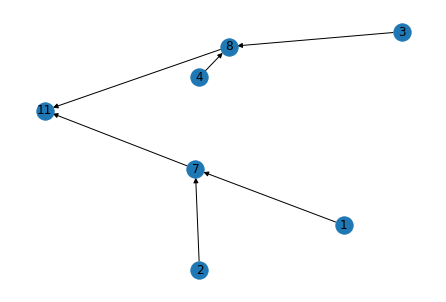

In [160]:
""" Break the graph in "irreducible" components of trees and loops """
G_skeleton = nx.DiGraph() #This will record connection nodes after we break down the ARG into simple components (trees and loops)
S = Sample_Nodes 
while len(S) > 0 :
    sample_connects = {} #For each s in S, this will record the earliest ancestor of s that is part of any loop
    for s in S: 
        if s == vGMRCA : 
            continue 
        
        group_connections = [vGMRCA] #This list will containt all the nodes in any loop that s is connected to. vGMRCA is included here for algorithmic purposes. 
        for g in nodes_in_all_groups : 
            if nx.has_path(G,s,g) and s != g:  
                group_connections += [g]
        
        earliest_connection = min(group_connections, key = lambda nd: G.nodes()[nd]['time']  )#Choose the earliest in group_connection
        sample_connects[s] = earliest_connection
        G_skeleton.add_node(earliest_connection, time= G.nodes()[earliest_connection]['time'] )
        G_skeleton.add_edge(s,earliest_connection, typ ='tree', paths = list(nx.all_simple_edge_paths(G,s,earliest_connection)) ) #To each edge in the skeleton, we all attribute all the paths between the two nodes in the real Graph. The attribute typ keeps track of whether this edge is part of a loop or a tree. typ attribute was mainly included for verification purposes and can eventually be removed. 
    
    loop_st_nds = list(sample_connects.values()) #This is the list of nodes in the loops which are connected to S 
    loop_st_nds_grpwise = { ind: list( set(Grp_details[ind]['nodes']).intersection(set(loop_st_nds))) for ind in Grp_details if len(list( set(Grp_details[ind]['nodes']).intersection(set(loop_st_nds)))) != 0 } #We divide and label these nodes according the group of loops they belong to.
    
    S_new = [] #The next set of S will be the the MRCA of each loop involved in this step
    for ind in loop_st_nds_grpwise : 
        loop_MRCA = Grp_details[ind]['maximum']
        S_new += [loop_MRCA]
        G_skeleton.add_node( loop_MRCA )
        for v in loop_st_nds_grpwise[ind]: 
            G_skeleton.add_edge(v,loop_MRCA, typ='loop', paths = list(nx.all_simple_edge_paths(G,v,loop_MRCA)))
    S = S_new
    # print('S',S)

    
nx.draw(G_skeleton, with_labels=True)

""" Compute the Matrix """
Gske_nodes = sorted(G_skeleton.nodes, key = lambda nd:G.nodes()[nd]['time']) #Ordering the nodes in the skeleton according to their times

#To each node in G_skeleton we will associcate two matrices. CovMatrix of a nodes will be the covariance matrix of all the paths from its immediate predecessor to itself where the CovFullMatrix will be the covariance matrix from the samples to itself. 

for v in Gske_nodes: 
    if v in Sample_Nodes:
        G_skeleton.add_node(v, CovMatrix = np.matrix([0]), CovMatrixFull = np.matrix([0]))
    else:    
        v_pred  = list(sorted(G_skeleton.predecessors(v), key = lambda nd:G.nodes()[nd]['time'])) #The predecessors nodes of v
        print(v, v_pred)
        n_pred = len(v_pred)
        CovMat = {} #This will record the CovMatrix between all the paths from the predecessors to v. This is stored as a dictionary of dictonary. The [v1][v2] entry is the covariance between paths from v1 to v and v2 to v. 
        CovMatFull = [] #This will record the CovMatrixFull which the covariance matrix from all paths from the samples to v
        for v1 in v_pred:
            Covrow = {}
            CovFullrow = []
            
            v1_paths = G_skeleton.edges()[(v1,v)]['paths']
            n1 = len(v1_paths)
            v1FullMat = G_skeleton.nodes()[v1]['CovMatrixFull'] #The covariance matrix between all paths from the samples to v1
            m1 = len(v1FullMat)
            
            for v2 in v_pred : 
                print('v2',v2)
                v2_paths = G_skeleton.edges()[(v2,v)]['paths']
                n2 = len(v2_paths)
                print('n2',n2)
                v2FullMat = G_skeleton.nodes()[v2]['CovMatrixFull'] #The covariance matrix between all paths from the samples to v2
                m2 = len(v2FullMat)
                
                Matv1v2 = np.matrix( [ [ Cov(path1,path2,G) for path2 in v2_paths] for path1 in v1_paths ] )
                MatFullv1v2 = np.kron(np.matrix(np.ones( (m1,m2) )), Matv1v2 )
                print('Matv1v2',Matv1v2)
                print('MatFullv1v2',MatFullv1v2)
                if v1 == v2 :
                    MatFullv1v2 = MatFullv1v2 + np.kron( v1FullMat, np.matrix(np.ones( (n1,n1) )) ) 
                Covrow[v2] = Matv1v2
                CovFullrow += [ MatFullv1v2 ]
            CovMat[v1] = Covrow
            CovMatFull += [CovFullrow ]
        
        G_skeleton.add_node(v, CovMatrix = CovMat, CovMatrixFull = np.bmat(CovMatFull))
CMFull = G_skeleton.nodes()[vGMRCA]['CovMatrixFull']

print(Gske_nodes)
print(CMFull)

""" Verification """ 

All_Paths = [] 
for s in Sample_Nodes:
    All_Paths +=  list(nx.all_simple_edge_paths(G, s, vGMRCA)) 

print(All_Paths)    
    
CM = [] 
for pathi in All_Paths :
    CMrow = []
    for pathj in All_Paths: 
        cij = Cov(pathi,pathj,G)
        CMrow += [ cij ]
    CM += [CMrow]
        
CM = np.matrix(CM)
print(CM)

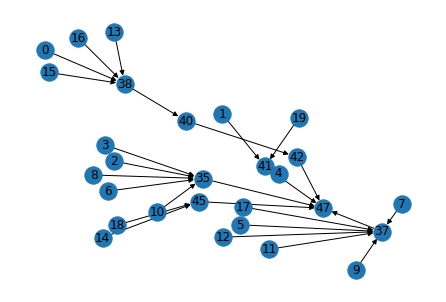

In [189]:
def locate_loops_ts(ts, cycle_root=-1):
    """
    Finds loops within the ARG. I thought that it would be easiest to utilize functions from
    networkx package. Identifies recombination events, converts the tree sequence into a networkx
    graph. The paired recombination nodes are merged together in this graph. Converts graph to 
    undirected, then calculates cycle basis. This does not identify 'bubbles', so we need to add
    an extra step to this.
    """
    
    if cycle_root < 0:
        cycle_root = ts.node(ts.num_nodes-1).id
    edges = ts.tables.edges
    parent_list = list(edges.parent)
    child_list = list(edges.child)
    recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
    g = ts_to_nx(ts=ts, connect_recombination_nodes=True, recomb_nodes=recomb_nodes)
    g = g.to_undirected()
    loop_list = nx.cycle_basis(g, root=cycle_root)
    if len(loop_list) != len(recomb_nodes)/2:
        for node in recomb_nodes[::2]:
            parent = parent_list[child_list.index(node)]
            if parent == parent_list[child_list.index(node+1)]:
                loop_list.append([node, parent])  
    return loop_list


ts = msprime.sim_ancestry(
    samples=10,
    recombination_rate=1e-8,
    sequence_length=2000,
    population_size=10_000,
    record_full_arg=True,
    random_seed=3439
)

start = time.time()
Sample_Nodes = list(ts.samples())
G = ts_to_nx(ts=ts, connect_recombination_nodes=True)
loops = locate_loops_ts(ts=ts) #Identify each loop as a list of nodes 
grouped_loops = group_loops(loops=loops) #Group the loops if they shared edges
vGMRCA = max(list(G.nodes()), key = lambda nd:G.nodes()[nd]['time'] ) #This is the GMRCA of the entire ARG identified as the oldest node in the ARG 
nodes_in_all_groups = [] #This will store all the nodes present in any loop in the Graph 
Grp_details = {} #This will store information about each group of nodes including the index of the group, the nodes in the group and the oldest node in the group
ind = 0 #This will keep track of the number of groups of loops present 
for Lp_grp in grouped_loops: 
    nodes_in_group = [] #To keep track of nodes in a given group of loops 
    for lp in Lp_grp: 
        nodes_in_group += lp
        nodes_in_all_groups += lp
    Grp_details[ind] = {'ind':ind, 'nodes': nodes_in_group, 'maximum': max(nodes_in_group, key = lambda nd: G.nodes()[nd]['time']) }
    ind += 1 
nodes_in_all_groups = set(nodes_in_all_groups)

G_skeleton = nx.DiGraph() #This will record connection nodes after we break down the ARG into simple components (trees and loops)
S = Sample_Nodes
while len(S) > 0 :
    sample_connects = {} #For each s in S, this will record the earliest ancestor of s that is part of any loop
    for s in S: 
        if s == vGMRCA : 
            continue 
        
        group_connections = [vGMRCA] #This list will containt all the nodes in any loop that s is connected to. vGMRCA is included here for algorithmic purposes. 
        for g in nodes_in_all_groups : 
            if nx.has_path(G,s,g) and s != g:  
                group_connections += [g]
        
        earliest_connection = min(group_connections, key = lambda nd: G.nodes()[nd]['time']  )#Choose the earliest in group_connection
        sample_connects[s] = earliest_connection
        G_skeleton.add_node(earliest_connection, time= G.nodes()[earliest_connection]['time'] )
        G_skeleton.add_edge(s,earliest_connection, typ ='tree', paths = list(nx.all_simple_edge_paths(G,s,earliest_connection)) ) #To each edge in the skeleton, we all attribute all the paths between the two nodes in the real Graph. The attribute typ keeps track of whether this edge is part of a loop or a tree. typ attribute was mainly included for verification purposes and can eventually be removed. 
    
    loop_st_nds = list(sample_connects.values()) #This is the list of nodes in the loops which are connected to S 
    loop_st_nds_grpwise = { ind: list( set(Grp_details[ind]['nodes']).intersection(set(loop_st_nds))) for ind in Grp_details if len(list( set(Grp_details[ind]['nodes']).intersection(set(loop_st_nds)))) != 0 } #We divide and label these nodes according the group of loops they belong to.
    
    S_new = [] #The next set of S will be the the MRCA of each loop involved in this step
    for ind in loop_st_nds_grpwise : 
        loop_MRCA = Grp_details[ind]['maximum']
        S_new += [loop_MRCA]
        G_skeleton.add_node( loop_MRCA )
        for v in loop_st_nds_grpwise[ind]: 
            G_skeleton.add_edge(v,loop_MRCA, typ='loop', paths = list(nx.all_simple_edge_paths(G,v,loop_MRCA)))
    S = S_new
    Gske_nodes = sorted(G_skeleton.nodes, key = lambda nd:G.nodes()[nd]['time']) #Ordering the nodes in the skeleton according to their times


nx.draw(G_skeleton, with_labels=True)

# Updated Hybrid Method Testing

## Flattening List

In [7]:
test_list_of_lists = [[[1,2,3],[0,3,6]],[[4,5]]]
for l in test_list_of_lists:
    print(set(sum(l, [])))

{0, 1, 2, 3, 6}
{4, 5}


In [177]:
import msprime
import tskit
import numpy as np
import math
import random
from collections import defaultdict
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt


class LoopGroup:
    def __init__(self, nodes, loop_list):
        self.nodes = set(nodes)
        self.youngest_node = min(nodes)
        self.oldest_node = max(nodes)
        self.loops = []
        for loop in loop_list:
            if loop[0] in self.nodes:
                self.loops.append(loop)
        """
        We may want to also have a networkx graph representation here.
        This would allow us to calculate all of the paths through the
        LoopGroup, needed for the covariance matrix.
        """
    
    def __str__(self):
        return f'LoopGroup contains {len(self.loops)} loop(s): {self.loops}'


def ts_to_nx(ts, connect_recombination_nodes=False, recomb_nodes=[]):
    """
    Converts tskit tree sequence to networkx graph.

    Need to add a check to ensure that the list of recombination nodes is valid
    (there should always be an even number of recombination nodes if following
    tskit setup)
    """
    if recomb_nodes == []:
        recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
    recomb_nodes_to_remove = recomb_nodes[1::2]
    topology = defaultdict(list)
    for tree in ts.trees():
        for k, v in chain(tree.parent_dict.items()):
            if connect_recombination_nodes:
                if v in recomb_nodes_to_remove:
                    v -= 1
                if k in recomb_nodes_to_remove:
                    k -= 1
                if v not in topology[k]:
                    topology[k].append(v)
            else:
                if v not in topology[k]:
                    topology[k].append(v)
    nx_graph = nx.DiGraph(topology)
    return nx_graph

def locate_loops_combo(nx_graph, ts=None):
    """
    Finds loops within the ARG. I thought that it would be easiest to utilize functions from
    networkx package. Identifies recombination events, converts the tree sequence into a networkx
    graph. The paired recombination nodes are merged together in this graph. Converts graph to 
    undirected, then calculates cycle basis. This does not identify 'bubbles', so we need to add
    an extra step to this.
    """
    
    loop_list = nx.cycle_basis(nx_graph.to_undirected())
    if ts:
        edges = ts.tables.edges
        parent_list = list(edges.parent)
        child_list = list(edges.child)
        recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
        if len(loop_list) != len(recomb_nodes)/2:
            for node in recomb_nodes[::2]:
                parent = parent_list[child_list.index(node)]
                if parent == parent_list[child_list.index(node+1)]:
                    loop_list.append([node, parent])
    return loop_list

def group_loops(loops, plot=False):
    """
    Groups intersecting loops in list. Builds networkx graph based on the loop list. Determines
    if the nodes are connected through the graph. Returns a list of lists of loops.
    """
    
    num_loops = len(loops)
    if num_loops == 0:
        return []
    else:
        if num_loops > 1:
            build_instructions = []
            for loop in loops:
                for n in range(len(loop)):
                    if n == len(loop)-1:
                        a, b = loop[n], loop[0]
                    else:
                        a, b = loop[n], loop[n+1]
                    build_instructions.append([a, b])
            g = nx.Graph(build_instructions)
            if plot:
                nx.draw(g, with_labels=True)
            grouped_nodes = list(nx.connected_components(g))
            grouped_loops = []
            for grouping in grouped_nodes:
                grouped_loops.append(LoopGroup(nodes=grouping, loop_list=loops))
            grouped_loops.sort(key=lambda x: x.youngest_node)
            return grouped_loops
        else:
            return [LoopGroup(nodes=loops[0], loop_list=loops)]

def strip_graph(nx_graph, ts, grouped_loops):
    """
    Creates a skeleton graph from the full graph
    """
    
    gmrca = ts.node(ts.num_nodes-1).id
    skeleton_topology = defaultdict(list)
    working_nodes = list(ts.samples())
    for node in working_nodes:
        no_shallower_connection = True
        for lg in grouped_loops:
            if node < lg.oldest_node:
                if nx.has_path(nx_graph, source=node, target=lg.oldest_node):
                    path = nx.shortest_path(nx_graph, source=node, target=lg.oldest_node)
                    youngest_connection_node = min(list(set(path) & lg.nodes))
                    skeleton_topology[node].append(youngest_connection_node)
                    if youngest_connection_node not in working_nodes:
                        if lg.oldest_node != gmrca:
                            working_nodes.append(lg.oldest_node)
                        skeleton_topology[youngest_connection_node].append(lg.oldest_node)
                    no_shallower_connection = False
                    break
        if no_shallower_connection:
            skeleton_topology[node].append(gmrca)
    return nx.DiGraph(skeleton_topology)

5023
44529.96┊     9   ┊     9   ┊  
        ┊   ┏━┻━┓ ┊   ┏━┻━┓ ┊  
15781.26┊   8   ┃ ┊   8   ┃ ┊  
        ┊  ┏┻━┓ ┃ ┊   ┃   ┃ ┊  
9037.85 ┊  7  ┃ ┃ ┊   7   ┃ ┊  
        ┊  ┃  ┃ ┃ ┊  ┏┻━┓ ┃ ┊  
2188.36 ┊  6  ┃ ┃ ┊  6  ┃ ┃ ┊  
        ┊ ┏┻┓ ┃ ┃ ┊ ┏┻┓ ┃ ┃ ┊  
1806.96 ┊ ┃ ┃ 4 ┃ ┊ ┃ ┃ 5 ┃ ┊  
        ┊ ┃ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┃ ┊  
0.00    ┊ 0 2 3 1 ┊ 0 2 3 1 ┊  
        0        862      2000 



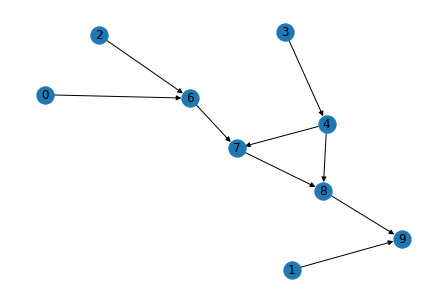

In [179]:
rs = random.randint(0,10000)
print(rs)

ts = msprime.sim_ancestry(
    samples=2,
    recombination_rate=1e-8,
    sequence_length=2000,
    population_size=10_000,
    record_full_arg=True,
    random_seed=rs
)

print(ts.draw_text())

G = ts_to_nx(ts=ts, connect_recombination_nodes=True)

nx.draw(G, with_labels=True)

loops = locate_loops_combo(nx_graph=G, ts=ts) #Identify each loop as a list of nodes 
grouped_loops = group_loops(loops=loops) #Group the loops if they shared edges
skeleton_G = strip_graph(nx_graph=G, ts=ts, grouped_loops=grouped_loops)

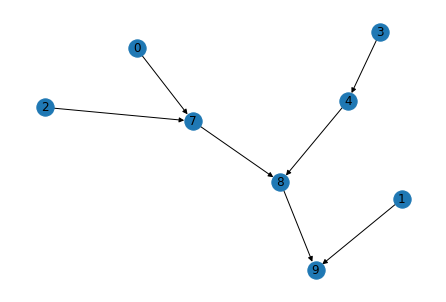

In [180]:
nx.draw(skeleton_G, with_labels=True)

In [65]:
print(grouped_loops[0])

LoopGroup contains 1 loop(s): [[6, 8]]


7603
46062.80┊         ┊   15    ┊   15    ┊   15    ┊  
        ┊         ┊  ┏━┻━┓  ┊  ┏━┻━┓  ┊  ┏━┻━┓  ┊  
30209.28┊         ┊ 14   ┃  ┊ 14   ┃  ┊ 14   ┃  ┊  
        ┊         ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
21959.26┊         ┊ 12   ┃  ┊ 12   ┃  ┊ 13   ┃  ┊  
        ┊         ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
9546.38 ┊   11    ┊  ┃  11  ┊  ┃  11  ┊  ┃  11  ┊  
        ┊  ┏━┻━┓  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
8268.55 ┊  ┃  10  ┊  ┃  10  ┊  ┃  10  ┊  ┃  10  ┊  
        ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
7430.64 ┊  ┃   8  ┊  ┃   8  ┊  ┃   9  ┊  ┃   9  ┊  
        ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
6753.12 ┊  6   ┃  ┊  7   ┃  ┊  7   ┃  ┊  7   ┃  ┊  
        ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
1629.22 ┊  5   ┃  ┊  5   ┃  ┊  5   ┃  ┊  5   ┃  ┊  
        ┊ ┏┻┓  ┃  ┊ ┏┻┓  ┃  ┊ ┏┻┓  ┃  ┊ ┏┻┓  ┃  ┊  
1604.41 ┊ ┃ ┃  4  ┊ ┃ ┃  4  ┊ ┃ ┃  4  ┊ ┃ ┃  4  ┊  
        ┊ ┃ ┃ ┏┻┓ ┊ ┃ ┃ ┏┻┓ ┊ ┃ ┃ ┏┻┓ ┊ ┃ ┃ ┏┻┓ ┊  
0.00    ┊ 0 1 2 3 ┊ 0 1 2 3 ┊ 0 1 2 3 ┊ 0 1 2 3 ┊  
       

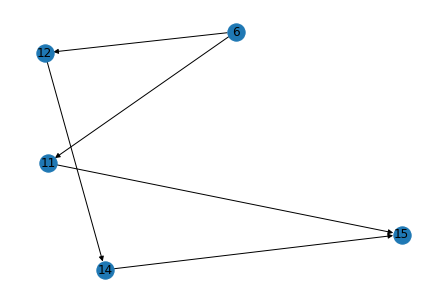

In [26]:
import msprime
import tskit
import numpy as np
import math
import random
from collections import defaultdict
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt


class LoopGroup:
    def __init__(self, nodes, loop_list, nx_graph):
        self.nodes = set(nodes)
        self.bubble_recomb_nodes = []
        self.loops = []
        for loop in loop_list:
            if loop[0] in self.nodes:
                self.loops.append(loop)
                if len(loop) == 2:
                    self.bubble_recomb_nodes.append(min(loop))
        self.nx_graph = nx_graph.copy()
        self.nx_graph.remove_nodes_from(G.nodes - self.nodes)
        self.youngest_node = min(nodes)
        self.input_node = max(nodes)
        self.output_nodes = [] 
        """
        I don't know what best practice is here. I don't want the attribute
        unless I've added to it. Should it be a list or set?
        """
        
        """
        We may want to also have a networkx graph representation here.
        This would allow us to calculate all of the paths through the
        LoopGroup, needed for the covariance matrix.
        """
    
    def __str__(self):
        return f'LoopGroup contains {len(self.loops)} loop(s): {self.loops}'
    
    def add_output_node(self, node):
        self.output_nodes.append(node)
        self.output_nodes.sort()
        
    def calc_paths(self):
        all_paths = []
        for node in self.output_nodes:
            output_paths = []
            paths = nx.all_simple_paths(self.nx_graph, source=node, target=self.input_node)
            if len(self.bubble_recomb_nodes) > 0:
                for p in paths:
                    additional_paths = [p]
                    for brn in self.bubble_recomb_nodes:
                        if brn in p:
                            new_paths = []
                            for ap in additional_paths:
                                for element in ap:
                                    if element == brn:
                                        element += 1
                                    new_paths.append(element)
                            additional_paths.append(new_paths)
                    output_paths.extend(additional_paths)
            all_paths.extend(output_paths)
        self.paths = all_paths
        return all_paths
    
    def calc_cov_matrix(self):
        paths = self.calc_paths()
        print(self.nx_graph.nodes()[self.youngest_node]["time"])
        
        """
        paths = self.calc_paths()
        edges = ts.tables.edges
        parent_list = list(edges.parent)
        child_list = list(edges.child)
        gmrca = ts.node(ts.num_nodes-1).id
        tgmrca = ts.node(gmrca).time
        times = np.empty((len(paths),len(paths)))
        for i, p in enumerate(paths):
            for j in range(i+1):
                intersect = list(set(p).intersection(paths[j]))
                intersect.sort()
                print(p, paths[j], intersect)
                if i == j:
                    times[i,j] = tgmrca
                elif intersect == [gmrca]:
                    times[i,j] = 0
                else:
                    edges = []
                    for child in intersect:
                        if child != gmrca:
                            print(child, parent_list[child_list.index(child)], ts.node(parent_list[child_list.index(child)]).time - ts.node(child).time)
                            edges.append(ts.node(parent_list[child_list.index(child)]).time - ts.node(child).time)
                    times[i,j] = np.sum(edges) # Do I need np.unique()? Ask Matt, because it was previously in his
                times[j,i] = times[i,j]
        self.cov_matrix = times
        return times
        """
            
            
            


def ts_to_nx(ts, connect_recombination_nodes=False, recomb_nodes=[]):
    """
    Converts tskit tree sequence to networkx graph.

    Need to add a check to ensure that the list of recombination nodes is valid
    (there should always be an even number of recombination nodes if following
    tskit setup)
    """
    if recomb_nodes == []:
        recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
    recomb_nodes_to_remove = recomb_nodes[1::2]
    topology = defaultdict(list)
    for tree in ts.trees():
        for k, v in chain(tree.parent_dict.items()):
            if connect_recombination_nodes:
                if v in recomb_nodes_to_remove:
                    v -= 1
                if k in recomb_nodes_to_remove:
                    k -= 1
                if v not in topology[k]:
                    topology[k].append(v)
            else:
                if v not in topology[k]:
                    topology[k].append(v)
    nx_graph = nx.DiGraph(topology)
    node_times = {v: k for v, k in enumerate(ts.tables.nodes.time)}
    nx.set_node_attributes(nx_graph, node_times, "time")
    return nx_graph

def locate_loops_combo(nx_graph, ts=None):
    """
    Finds loops within the ARG. I thought that it would be easiest to utilize functions from
    networkx package. Identifies recombination events, converts the tree sequence into a networkx
    graph. The paired recombination nodes are merged together in this graph. Converts graph to 
    undirected, then calculates cycle basis. This does not identify 'bubbles', so we need to add
    an extra step to this.
    """
    
    loop_list = nx.cycle_basis(nx_graph.to_undirected())
    if ts:
        edges = ts.tables.edges
        parent_list = list(edges.parent)
        child_list = list(edges.child)
        recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
        if len(loop_list) != len(recomb_nodes)/2:
            for node in recomb_nodes[::2]:
                parent = parent_list[child_list.index(node)]
                if parent == parent_list[child_list.index(node+1)]:
                    loop_list.append([node, parent])
    return loop_list

def group_loops(loops, ts=None, plot=False):
    """
    Groups intersecting loops in list. Builds networkx graph based on the loop list. Determines
    if the nodes are connected through the graph. Returns a list of lists of loops.
    """
    
    num_loops = len(loops)
    if num_loops == 0:
        return []
    else:
        if num_loops > 1:
            build_instructions = []
            for loop in loops:
                for n in range(len(loop)):
                    if n == len(loop)-1:
                        a, b = loop[n], loop[0]
                    else:
                        a, b = loop[n], loop[n+1]
                    if a > b:
                        build_instructions.append([b, a])
                    else:
                        build_instructions.append([a, b])
            g = nx.DiGraph(build_instructions)
            if ts:
                node_times = {v: k for v, k in enumerate(ts.tables.nodes.time)}
                nx.set_node_attributes(g, node_times, "time")
            if plot:
                nx.draw(g, with_labels=True)
            grouped_nodes = list(nx.connected_components(g.to_undirected()))
            grouped_loops = []
            for grouping in grouped_nodes:
                grouped_loops.append(LoopGroup(nodes=grouping, loop_list=loops, nx_graph=g))
            grouped_loops.sort(key=lambda x: x.youngest_node)
            return grouped_loops
        else:
            return [LoopGroup(nodes=loops[0], loop_list=loops)]

def strip_graph(nx_graph, ts, grouped_loops):
    """
    Creates a skeleton graph from the full graph
    """
    
    gmrca = ts.node(ts.num_nodes-1).id
    all_loop_nodes = set([node for loop in grouped_loops for node in loop.nodes])
    skeleton_topology = defaultdict(list)
    previously_found = []
    working_nodes = list(ts.samples())
    for node in working_nodes:
        no_shallower_connection = True
        for lg in grouped_loops:
            if node < lg.input_node:
                if nx.has_path(nx_graph, source=node, target=lg.input_node):
                    path = nx.shortest_path(nx_graph, source=node, target=lg.input_node)
                    youngest_connection_node = min(list(set(path[1:]) & all_loop_nodes))
                    if youngest_connection_node not in lg.nodes:
                        continue
                    skeleton_topology[node].append(youngest_connection_node)
                    if youngest_connection_node not in previously_found:
                        skeleton_topology[youngest_connection_node].append(lg.input_node)
                        previously_found.append(youngest_connection_node)
                        lg.add_output_node(youngest_connection_node)
                    if lg.input_node != gmrca and lg.input_node not in working_nodes:
                        working_nodes.append(lg.input_node)
                    no_shallower_connection = False
                    break
        if no_shallower_connection:
            skeleton_topology[node].append(gmrca)
    return nx.DiGraph(skeleton_topology)




rs = random.randint(0,10000)
print(rs)

ts = msprime.sim_ancestry(
    samples=2,
    recombination_rate=1e-8,
    sequence_length=2000,
    population_size=10_000,
    record_full_arg=True,
    random_seed=7483
)

print(ts.draw_text())

G = ts_to_nx(ts=ts, connect_recombination_nodes=True)
loops = locate_loops_combo(nx_graph=G, ts=ts) #Identify each loop as a list of nodes 
grouped_loops = group_loops(loops=loops, ts=ts) #Group the loops if they shared edges
skeleton_G = strip_graph(nx_graph=G, ts=ts, grouped_loops=grouped_loops)

#nx.draw(skeleton_G, with_labels=True)

nx.draw(grouped_loops[0].nx_graph, with_labels=True)

for lg in grouped_loops:
    print(lg.bubble_recomb_nodes)
    print(lg.calc_cov_matrix())
    print(lg.paths)

In [17]:
from IPython.display import IFrame

width = 700 - 200
height = 600 - 100

w_spacing = width / (ts.num_samples - 1)
h_spacing = height / (ts.num_nodes - ts.num_samples - np.count_nonzero(ts.tables.nodes.flags == 131072)/2)

ordered_nodes = []
for node in ts.first().nodes(order="minlex_postorder"):
    if node < ts.num_samples:
        ordered_nodes.append(node)

nodes = []
node_index = 0
fy = 0
skip_recomb = True
recomb_nodes = []
mc_nodes = []
for node in ts.tables.nodes:
    if node.flags == 1:
        nodes.append({"id": node_index, "label": node_index, "flag": node.flags, "fx": ordered_nodes.index(node_index)*w_spacing+100, "fy": height-(fy*h_spacing-50)})
    elif node.flags == 131072:
        if skip_recomb:
            fy += 1
            child = ts.tables.edges[np.where(ts.tables.edges.parent == node_index)[0]].child[0]
            nodes.append({"id": node_index, "label": str(node_index)+"/"+str(node_index+1), "flag": node.flags, "xref": child, "fy": height-(fy*h_spacing)+50})
            skip_recomb = False
        else:
            recomb_nodes.append(node_index)
            skip_recomb = True
    elif node.flags == 262144:
        mc_nodes.append(node_index)
        fy += 1
        child = ts.tables.edges[np.where(ts.tables.edges.parent == node_index)[0]].child[0]
        nodes.append({"id": node_index, "label": node_index, "flag": node.flags, "xref": child, "fy": height-(fy*h_spacing)+50})
    else:
        fy += 1
        nodes.append({"id": node_index, "label": node_index, "flag": node.flags, "fy": height-(fy*h_spacing)+50})
    node_index += 1

already_found = []
links = []
for edge in ts.tables.edges:
    direction = ""
    if edge.parent in recomb_nodes:
        pass
    else:
        if edge.child in recomb_nodes:
            c = edge.child - 1
        else:
            c = edge.child
        if edge.parent in mc_nodes:
            if edge.parent not in already_found:
                already_found.append(edge.parent)
                direction = 0
            else:
                direction = 1
        links.append({"source": edge.parent, "target": c, "direction":direction})

        
with open("arg.js", "w") as outfile:
    outfile.write("var graph = {\n")
    outfile.write("\tnodes: " + str(nodes) + ",\n")
    outfile.write("\tlinks: " + str(links) + "\n")
    outfile.write("};")
    
display(IFrame(src='./index.html', width=800, height=650))

print(ts.draw_text())

46062.80┊         ┊   15    ┊   15    ┊   15    ┊  
        ┊         ┊  ┏━┻━┓  ┊  ┏━┻━┓  ┊  ┏━┻━┓  ┊  
30209.28┊         ┊ 14   ┃  ┊ 14   ┃  ┊ 14   ┃  ┊  
        ┊         ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
21959.26┊         ┊ 12   ┃  ┊ 12   ┃  ┊ 13   ┃  ┊  
        ┊         ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
9546.38 ┊   11    ┊  ┃  11  ┊  ┃  11  ┊  ┃  11  ┊  
        ┊  ┏━┻━┓  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
8268.55 ┊  ┃  10  ┊  ┃  10  ┊  ┃  10  ┊  ┃  10  ┊  
        ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
7430.64 ┊  ┃   8  ┊  ┃   8  ┊  ┃   9  ┊  ┃   9  ┊  
        ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
6753.12 ┊  6   ┃  ┊  7   ┃  ┊  7   ┃  ┊  7   ┃  ┊  
        ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  ┃   ┃  ┊  
1629.22 ┊  5   ┃  ┊  5   ┃  ┊  5   ┃  ┊  5   ┃  ┊  
        ┊ ┏┻┓  ┃  ┊ ┏┻┓  ┃  ┊ ┏┻┓  ┃  ┊ ┏┻┓  ┃  ┊  
1604.41 ┊ ┃ ┃  4  ┊ ┃ ┃  4  ┊ ┃ ┃  4  ┊ ┃ ┃  4  ┊  
        ┊ ┃ ┃ ┏┻┓ ┊ ┃ ┃ ┏┻┓ ┊ ┃ ┃ ┏┻┓ ┊ ┃ ┃ ┏┻┓ ┊  
0.00    ┊ 0 1 2 3 ┊ 0 1 2 3 ┊ 0 1 2 3 ┊ 0 1 2 3 ┊  
        0   

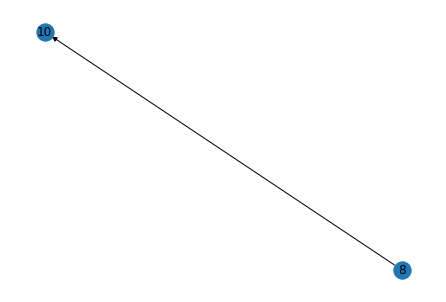

In [18]:
nx.draw(grouped_loops[1].nx_graph, with_labels=True)